In [7]:
import os
import pandas as pd
import numpy as np
import re

listops_dir = 'listops-1000'

train_file_path = os.path.join(listops_dir, 'basic_train.tsv')  
val_file_path = os.path.join(listops_dir, 'basic_val.tsv')  
test_file_path = os.path.join(listops_dir, 'basic_test.tsv')  

In [9]:
def load_file(file_name):
    data = pd.read_csv(file_name)
    
    def split_sequence(sequence):
        tokens = sequence.split('\t')  # Split the sequence into tokens
        source = tokens[0] # Join all tokens except the last one for Source
        target = tokens[1]  # Last token is the Target
        return source, target
    
    data['Source'], data['Target'] = zip(*data['Source\tTarget'].map(split_sequence))
    data.drop(columns=['Source\tTarget'], inplace=True)
    return data

In [10]:
train_df = load_file(train_file_path)
val_df = load_file(val_file_path)
test_df = load_file(test_file_path)

In [11]:
train_df['Token_Count'] = train_df['Source'].apply(lambda x: len(re.findall(r'(MIN|MAX|MED|SM|\d+|\(|\)|\[|\])', x)))
val_df['Token_Count'] = val_df['Source'].apply(lambda x: len(re.findall(r'(MIN|MAX|MED|SM|\d+|\(|\)|\[|\])', x)))
test_df['Token_Count'] = test_df['Source'].apply(lambda x: len(re.findall(r'(MIN|MAX|MED|SM|\d+|\(|\)|\[|\])', x)))

In [12]:
print('max length from train sequences', max(train_df['Token_Count']))
print('max length from val sequences', max(val_df['Token_Count']))
print('max length from test sequences', max(test_df['Token_Count']))

max length from train sequences 6293
max length from val sequences 6278
max length from test sequences 6276


In [13]:
ranges = [(0, 2000), (2000, 3000), (3000, 4000), (4000, 5000), (5000, 6000), (6000, float('inf'))]

train_df['Length_Range'] = pd.cut(train_df['Token_Count'], bins=[left for left, right in ranges] + [float('inf')], labels=[f"{left}-{right}" for left, right in ranges])
val_df['Length_Range'] = pd.cut(val_df['Token_Count'], bins=[left for left, right in ranges] + [float('inf')], labels=[f"{left}-{right}" for left, right in ranges])
test_df['Length_Range'] = pd.cut(test_df['Token_Count'], bins=[left for left, right in ranges] + [float('inf')], labels=[f"{left}-{right}" for left, right in ranges])

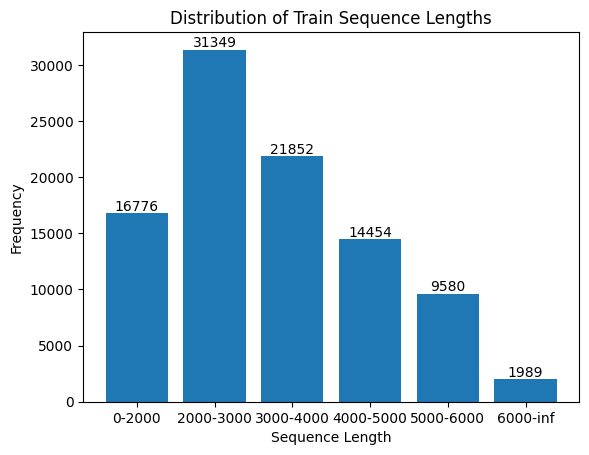

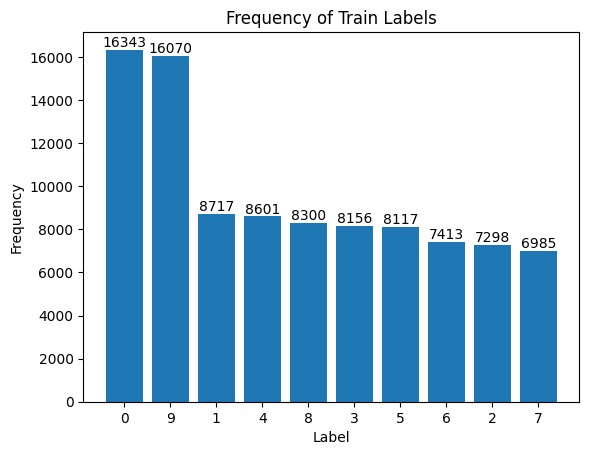

In [14]:
import matplotlib.pyplot as plt
import re

# Explore the distribution of sequence lengths
length_counts = train_df['Length_Range'].value_counts().sort_index()
plt.bar(length_counts.index, length_counts.values)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Train Sequence Lengths')

for i, value in enumerate(length_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')
    
plt.show()

label_counts = train_df['Target'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Train Labels')

for i, value in enumerate(label_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()


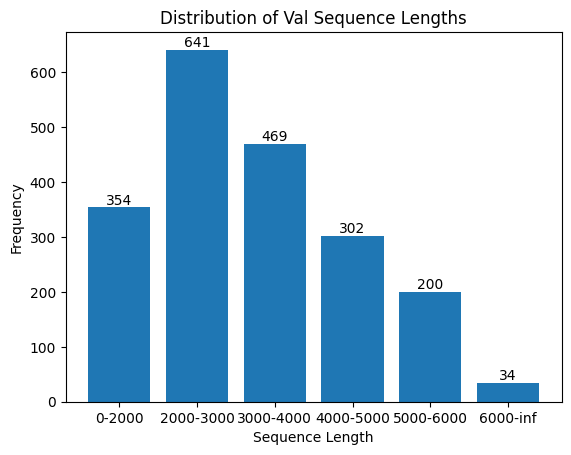

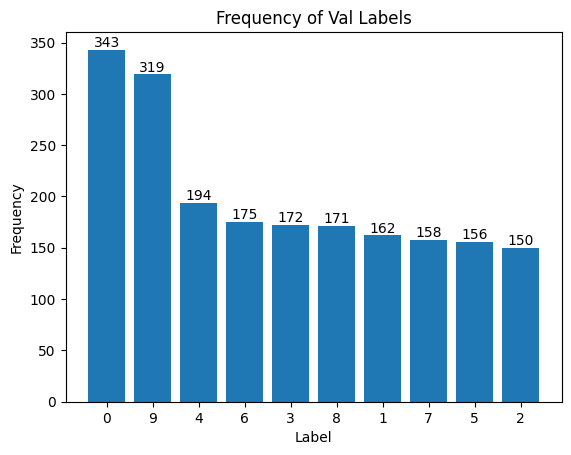

In [15]:
import matplotlib.pyplot as plt
import re

# Explore the distribution of sequence lengths
length_counts = val_df['Length_Range'].value_counts().sort_index()
plt.bar(length_counts.index, length_counts.values)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Val Sequence Lengths')

for i, value in enumerate(length_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')
    
plt.show()

label_counts = val_df['Target'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Val Labels')

for i, value in enumerate(label_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()


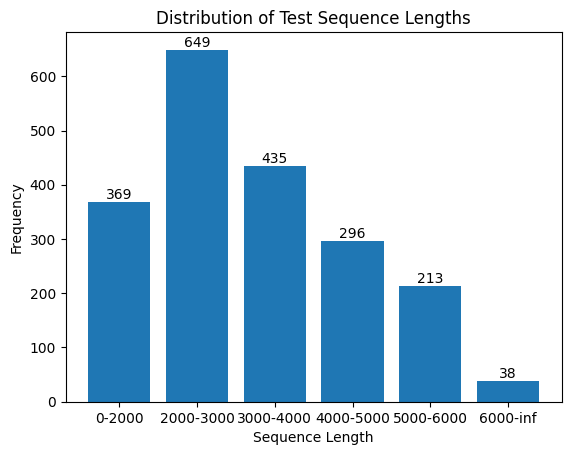

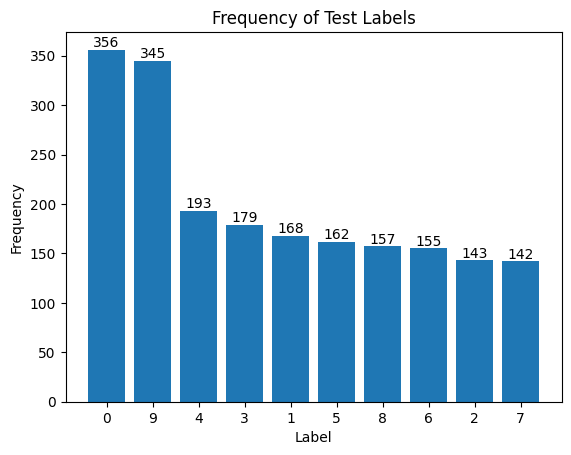

In [16]:
import matplotlib.pyplot as plt
import re

# Explore the distribution of sequence lengths
length_counts = test_df['Length_Range'].value_counts().sort_index()
plt.bar(length_counts.index, length_counts.values)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Test Sequence Lengths')

for i, value in enumerate(length_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')
    
plt.show()

label_counts = test_df['Target'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Test Labels')

for i, value in enumerate(label_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

In [17]:
token_dict = {
    '0': 0, 
    '1': 1, 
    '2': 2, 
    '3': 3, 
    '4': 4, 
    '5': 5, 
    '6': 6, 
    '7': 7, 
    '8': 8, 
    '9': 9, 
    '(': 10, 
    ')': 11, 
    '[': 12, 
    ']': 13, 
    'MIN': 14, 
    'MAX': 15, 
    'SM': 16, 
    'MED': 17
}

In [23]:
import numpy as np

max_sequence_length = 6293 #max length sequence from train dataset

def tokenize(row):
    tokens = re.findall(r'(MIN|MAX|MED|SM|\d+|\(|\)|\[|\])', row)
    return [token_dict[t] for t in tokens]

def pad_sequences(sequences, sequence_size=6293):
    # Initialize a new numpy array to store padded sequences
    padded_sequences = np.zeros((len(sequences), sequence_size), dtype=np.int32)
    
    # Pad each sequence with zeros to match the maximum length
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = seq
    
    return np.asarray(padded_sequences)

def processData(data):
    X_array = data['Source'].apply(tokenize)  # Apply function row-wise

    # Convert the result to a numpy array
    X = np.array(X_array)
    padded_X = pad_sequences(X, max_sequence_length)
    y = data['Target']
    return padded_X, y

In [19]:
def saveProcessedData(X, y, filepath):
    combined_data = np.column_stack((X, y))
    np.savetxt(filepath, combined_data, delimiter=',', fmt='%s')

In [24]:
#X_train, y_train = processData(train_df)
X_val, y_val = processData(val_df)
X_test, y_test = processData(test_df)

In [25]:
#saveProcessedData(X_train, y_train, os.path.join(listops_dir, 'train.csv'))
saveProcessedData(X_val, y_val, os.path.join(listops_dir, 'val.csv'))
saveProcessedData(X_test, y_test, os.path.join(listops_dir, 'test.csv'))

In [26]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(96000, 6293)
(2000, 6293)
(2000, 6293)
